In [133]:
import os
import wave
import numpy as np
import soundfile as sf
import tensorflow as tf
import imageio.v2 as imageio
import tensorflow_hub as hub
from pydub import AudioSegment
from librosa import stft, istft
from matplotlib import pyplot as plt
from IPython.display import Audio as disp_audio, Video as disp_video

__import__("importlib").reload(__import__("utils"))

from utils import type_DFT, DFT_Pipeline
from utils import disp_specto, disp_wav, load, disp_model_specto

In [2]:
SONG_FILE = "no_role_modelz.wav"
IS_INSTRUMENTAL = False

Make the file in `.wav` format

In [12]:
# check if in mp3 format
if (ext:=SONG_FILE.split('.')[-1]) in ['mp3', 'flv', 'ogg', 'raw']:

    # convert to wav
    sound = eval(f"AudioSegment.from_{ext}(f'songs/{{SONG_FILE}}')")
    os.system(f"rm songs/{SONG_FILE}")
    SONG_NAME = SONG_FILE.removesuffix(f'.{ext}')
    sound.export(f"songs/{SONG_NAME}.wav", format="wav")

else:
    
    # change to just the name of the file
    SONG_NAME = SONG_FILE.removesuffix('.wav')

Show segment

In [13]:
song, rate = load(SONG_NAME, instr=False)

# determine slice for the rest of the thing 
SONG_SLICE = slice(190*rate, 200*rate)
CLIP_LENGTH = 10

disp_audio(data=song[SONG_SLICE], rate=rate)

Generate instrumental of the track

In [14]:
# credit to https://github.com/tsurumeso/vocal-remover
if IS_INSTRUMENTAL:
    sound = AudioSegment.from_wav(f"songs/{SONG_NAME}.wav")
    sound.export(f"songs/{SONG_NAME}_instr.wav", format="wav")
elif f"{SONG_NAME}_instr.wav" not in os.listdir('songs'):
    _ = os.system(f"./sep_instr.sh {SONG_NAME}")
song, rate = load(SONG_NAME)
disp_audio(data=song[SONG_SLICE], rate=rate)

Display waveform of slice

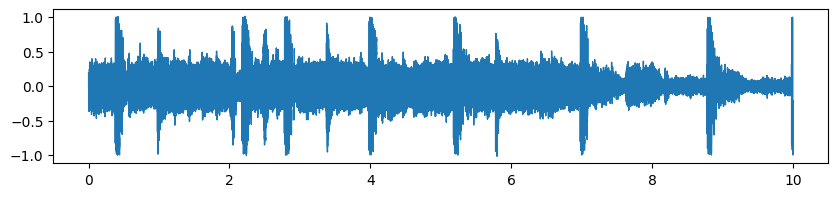

In [15]:
disp_wav(*load(SONG_NAME), SONG_SLICE)

Display spectograph of slice

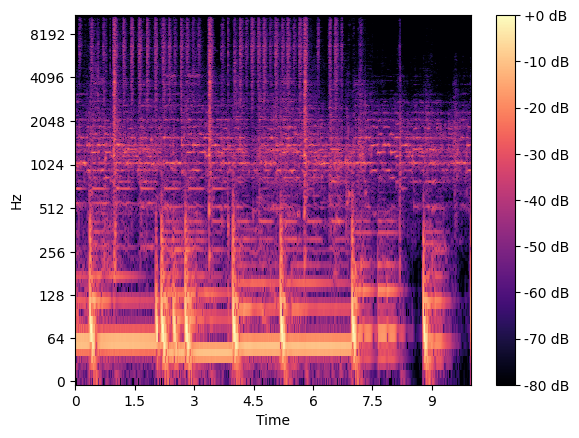

In [16]:
song, _ = load(SONG_NAME)
s = stft(song[SONG_SLICE])
disp_specto(s)

Display the frequencies in a video

In [19]:
song, RATE = load(SONG_NAME)
AUDIO = song[SONG_SLICE]
s = stft(AUDIO)
TEMP_DIR = "tmp"

if TEMP_DIR not in os.listdir():
    os.mkdir(TEMP_DIR)

# swap axis 0 to represent time rather than freq
t = np.array([s[:, i] for i in range(s.shape[1])])
frames_per_second = len(t) // CLIP_LENGTH

# graph each one with mpl
for i, a in enumerate(t):
    plt.plot(a)
    plt.xscale("log")
    plt.xlim(1, 1000)
    plt.ylim(0, 100)
    plt.savefig(f"{TEMP_DIR}/{str(i).zfill(10)}.png")
    plt.close()

# turn it into a video
sf.write(f"{TEMP_DIR}/audio.mp3", AUDIO, RATE, format="mp3")

images = [imageio.imread(f"{TEMP_DIR}/{img}") for img in filter(
    lambda x: x.endswith(".png"), os.listdir(TEMP_DIR)
)]
imageio.mimsave(f"video.mp4", images, fps=frames_per_second)

for filename in os.listdir(TEMP_DIR):
    os.remove(f"{TEMP_DIR}/{filename}")

disp_video("video.mp4")

Remove weaker frequencies

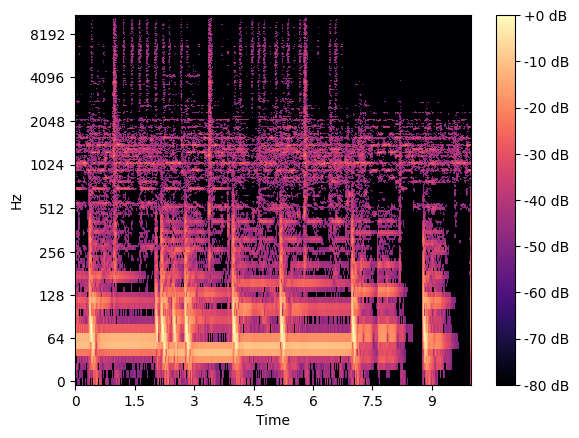

In [40]:
cap = np.vectorize(lambda x: max(0, x))
def remove_weak_freqs(s: type_DFT) -> type_DFT:

    s = np.abs(s)
    
    # compute average of all the frequencies summed up
    avg = np.average(s)

    # calculate mask
    diffs: np.ndarray = cap(s - np.full_like(s, avg))
    mask = diffs.astype(np.bool_).astype(np.uint8)

    # apply mask
    return s * mask

song, rate = load(SONG_NAME)
s = remove_weak_freqs(stft(song[SONG_SLICE]))
filtered_song = istft(s)
disp_specto(s)
disp_audio(data=filtered_song, rate=rate)

(Attempt to) remove hi-hat and snares

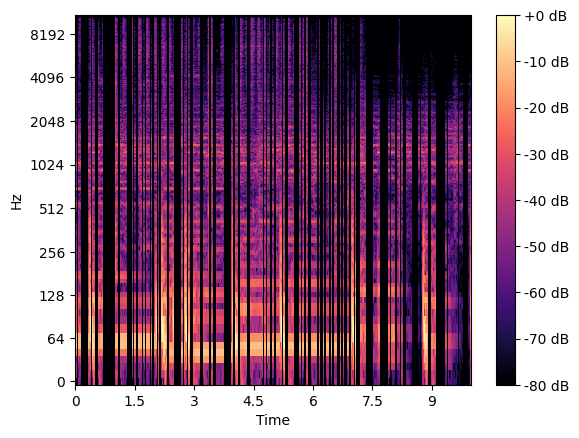

In [28]:
def remove_percussion(s: type_DFT) -> type_DFT:
    
    # compute average of all the frequencies summed up
    zipped = np.array([s[:, i] for i in range(s.shape[1])])
    average_sum = np.average(np.array([np.sum(song[i]) for i in range(zipped.shape[0])]))

    # now do the removing
    for t in range(s.shape[1]):
        if np.sum(s[:, t]) > average_sum:
            s[:, t] = 0   

    return s

song, rate = load(SONG_NAME)
s = remove_percussion(stft(song[SONG_SLICE]))
disp_specto(s)
disp_audio(istft(s), rate=rate)

Find frequences that are higher than the previous ones

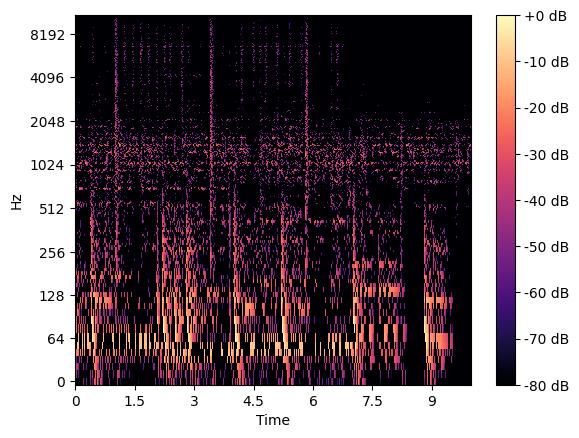

In [36]:
cap = np.vectorize(lambda x: max(0, x))

def sharpen_sounds(s: type_DFT) -> type_DFT:
    s = abs(s)
    new_s = np.zeros_like(s)
    for idx, freq_array in enumerate(s):
        shift_forward = np.array([0, *freq_array])
        shift_back = np.array([*freq_array, 0])
        diff: np.ndarray = cap(shift_forward - shift_back)
        mask = diff.astype(np.bool_).astype(np.uint8)
        new_s[idx] = mask[:-1] * freq_array
    return new_s

song, rate = load(SONG_NAME)
s = sharpen_sounds(stft(song[SONG_SLICE]))
disp_specto(s)
disp_audio(data=istft(s), rate=rate)

Filter frequencies too high or low

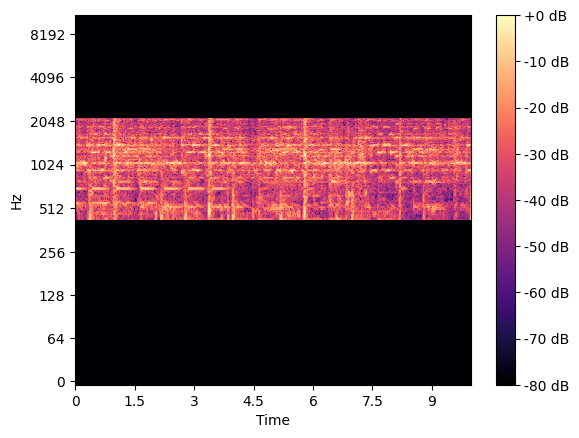

In [37]:
def filter_extreme(s: type_DFT, low: int, max: int) -> type_DFT:
    s[:low] = 0
    s[max:] = 0 
    return s

song, rate = load(SONG_NAME)
s = filter_extreme(stft(song[SONG_SLICE]), 40, 200)
disp_specto(s)
disp_audio(data=istft(s), rate=rate)

Find extended notes

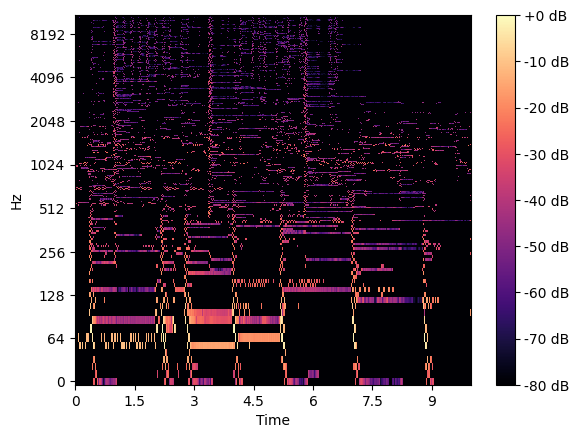

In [38]:
def clean_timeline(t: np.ndarray, start_thresh: float, end_thresh) -> np.ndarray:
    # standarize array
    Z = (t - t.mean()) / t.std()

    # find drastic note entrances
    diff = np.array([0, *Z]) - np.array([*Z, 0])
    entrances = diff > start_thresh
    closes = diff < -end_thresh

    # intervals for the notes, (1, 0, 0, -1) is an interval
    big_diff = (entrances.astype(np.int8) - closes.astype(np.int8))[:-1]

    # join each entrance to the following close
    intervals = []
    lf_open = True
    for idx, n in enumerate(big_diff):
        if lf_open and n == 1:
            temp_int = (idx,)
            lf_open = False
        elif not lf_open and n == -1:
            temp_int += (idx,)
            intervals.append(temp_int)
            lf_open = True

    # generate mask
    mask = np.zeros_like(t)
    for open, close in intervals:
        mask[open:close] = 1

    return mask * t
    
def clean_notes(s: type_DFT, z_thresh: tuple[float]) -> type_DFT:
    return np.apply_along_axis(clean_timeline, 1, s, *z_thresh)

song, rate = load(SONG_NAME)
s = clean_notes(stft(song[SONG_SLICE]), (1.5, 0.75))
disp_specto(s)
disp_audio(data=istft(s), rate=rate)

Create pipeline and run the files through

Pipeline:
├─ clean_notes, args: (2.0, 1.0)
├─ filter_extreme, args: 40 200
└─ remove_weak_freqs



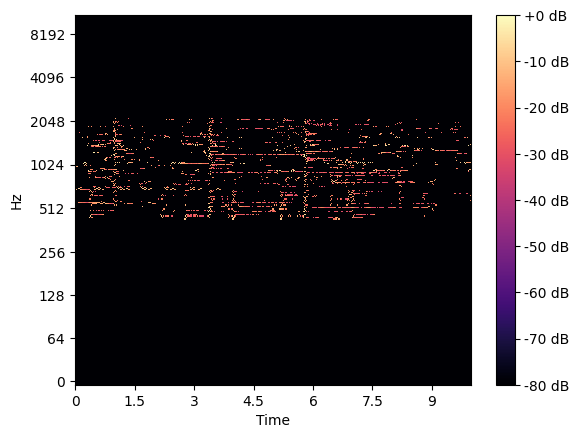

In [165]:
# create pipeline
PIPELINE = DFT_Pipeline()
PIPELINE.add(clean_notes, (2.0, 1.0))
PIPELINE.add(filter_extreme, 40, 200)
PIPELINE.add(remove_weak_freqs)
print(PIPELINE)

song, rate = load(SONG_NAME)
s = PIPELINE(stft(song[SONG_SLICE]))
new_song = istft(s)
disp_specto(s)
sf.write(f'songs/{SONG_NAME}_pipe.wav', new_song, rate)
disp_audio(new_song, rate=rate)

### This is an attempt to isolate the main notes of the song with pitch detection

In [95]:
# make the sample rate 16hz for model
audio = AudioSegment.from_file(f"songs/{SONG_NAME}_pipe.wav")
audio = audio.set_frame_rate(16000).set_channels(1)
audio.export(f"songs/{SONG_NAME}_proc.wav", format="wav")

<_io.BufferedRandom name='songs/no_role_modelz_proc.wav'>

Display information about new file

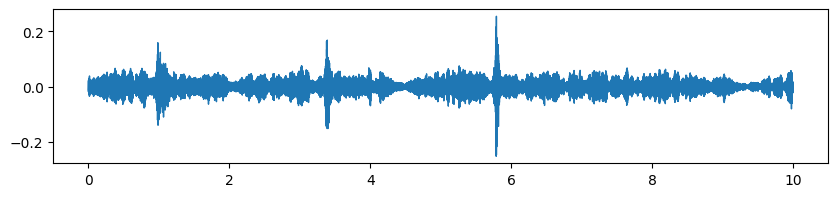

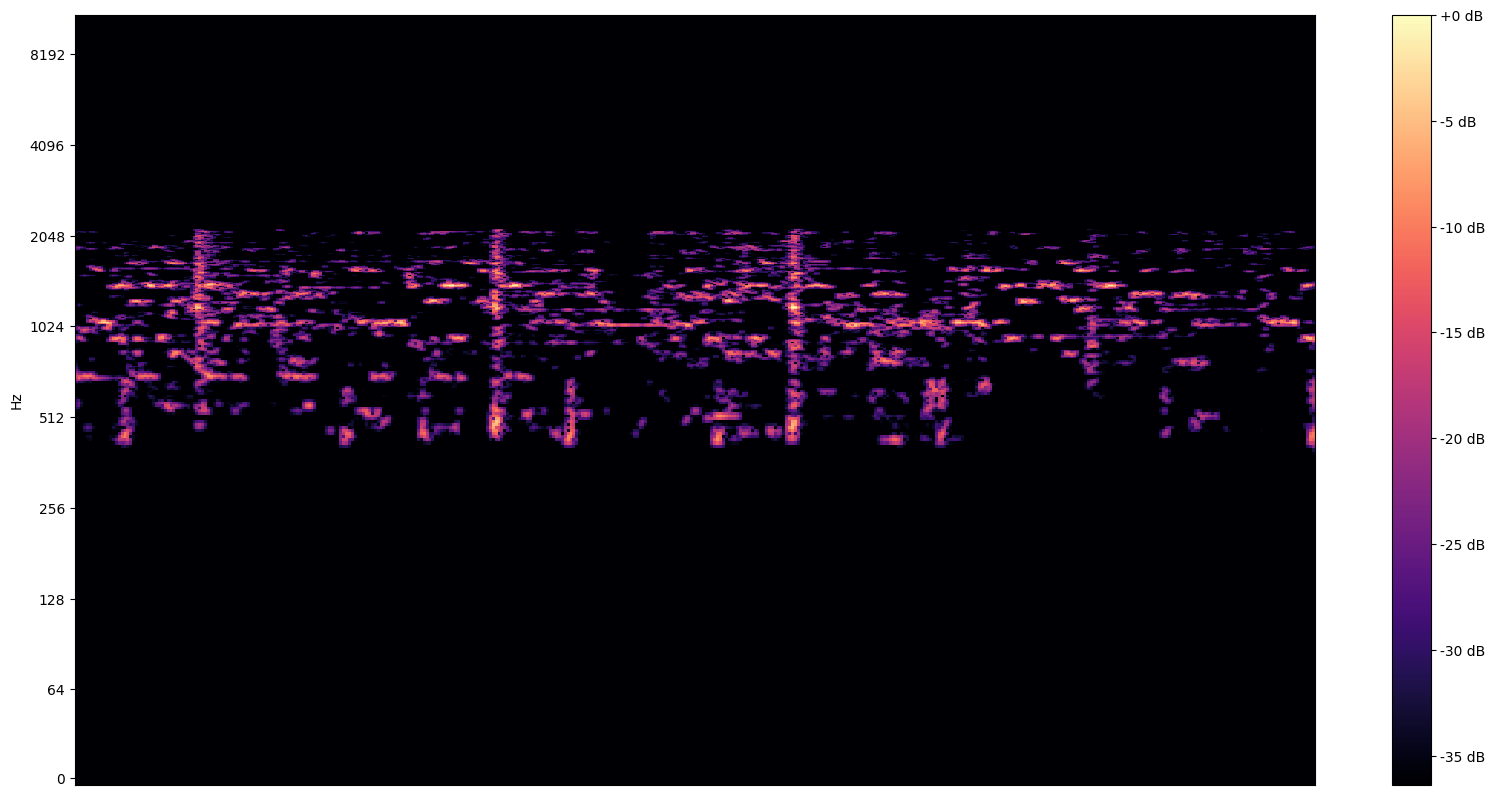

In [143]:
processed_song, rate = load(f"{SONG_NAME}_proc", instr=False)
SONG_SLICE = slice(190*rate, 200*rate)
MODEL_SONG = processed_song[SONG_SLICE]
disp_wav(processed_song, rate=rate, slice=SONG_SLICE)
disp_model_specto(MODEL_SONG / 32768, sample_rate=rate)
plt.show()
disp_audio(MODEL_SONG, rate=rate)

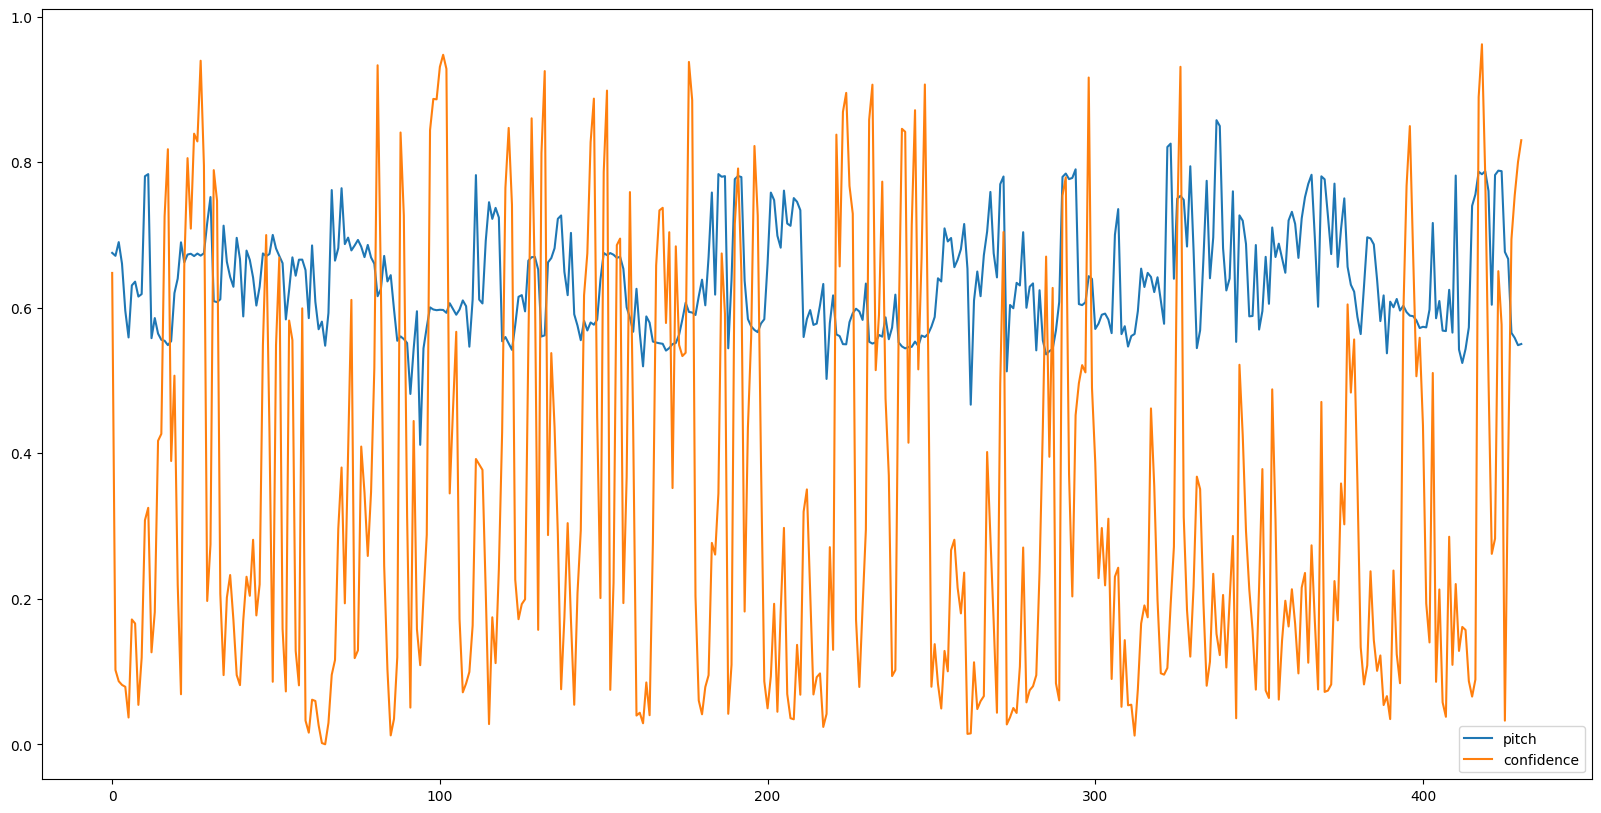

In [149]:
model = hub.load("https://tfhub.dev/google/spice/2")
output = model.signatures["serving_default"](tf.constant(MODEL_SONG, tf.float32))
pitches, confidences = output["pitch"], 1.0 - output["uncertainty"]

FFT_RATE_FACTOR = len(MODEL_SONG) / len(pitches)

# show pitches and confidence
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitches, label='pitch')
plt.plot(confidences, label='confidence')
plt.legend(loc="lower right")
plt.show()

Convert to Hz

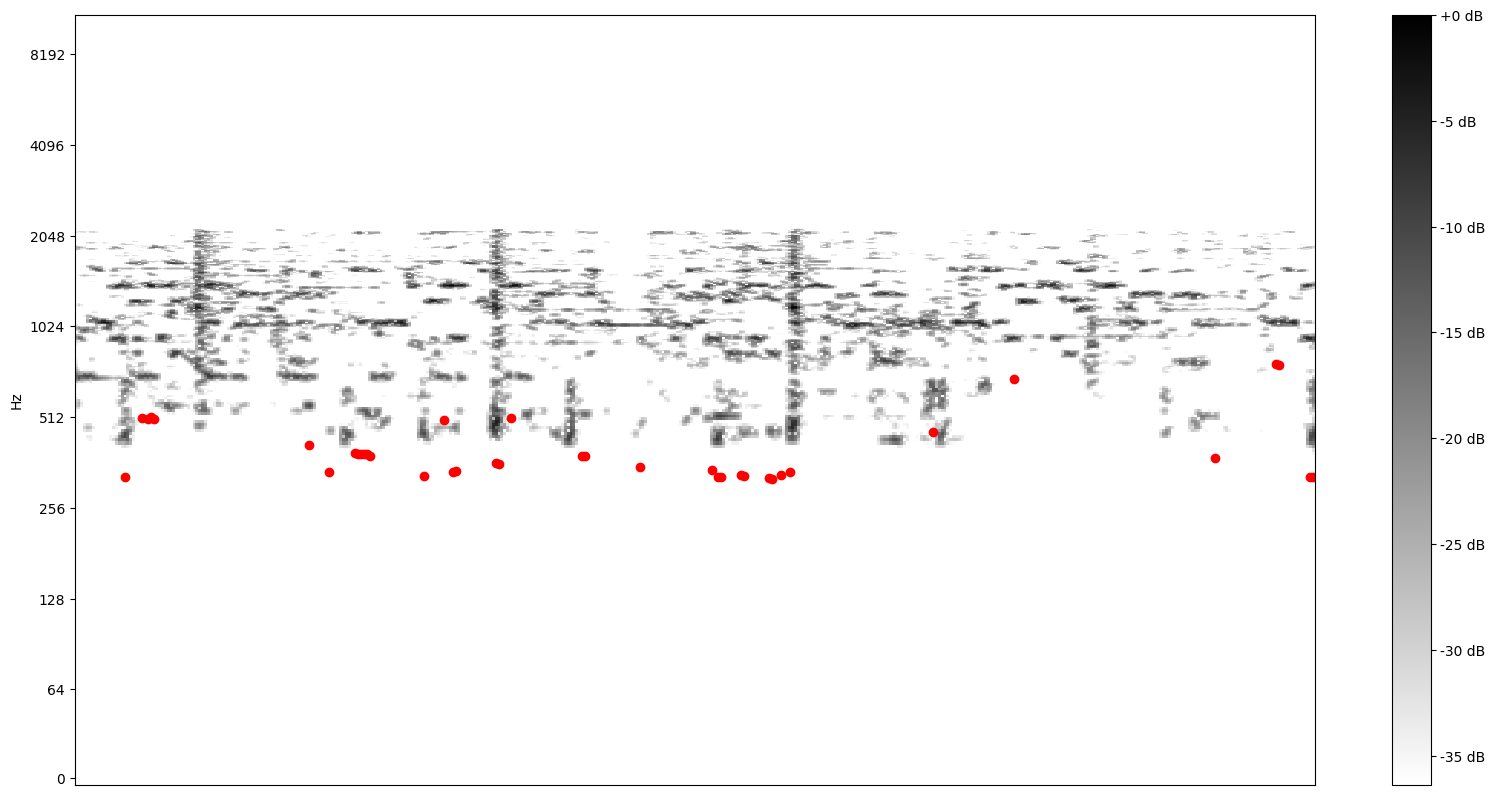

In [155]:
# Constants taken from https://tfhub.dev/google/spice/2
def model_to_hz(pitch: float):
    PT_OFFSET = 25.58
    PT_SLOPE = 63.07
    FMIN = 10.0
    BINS_PER_OCTAVE = 12.0
    cqt_bin = pitch * PT_SLOPE + PT_OFFSET
    return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

indeces = np.arange(pitches.shape[0])
conf_pitches = [
    (i, pitch) for (i, pitch, conf) in 
    zip(indeces, pitches, confidences)
    if conf > 0.8
]

conf_pitches_hz = [
    (i, model_to_hz(pitch)) for i, pitch in conf_pitches
]

disp_model_specto(MODEL_SONG / 32768, sample_rate=rate, show_black_and_white=True)
plt.scatter(*zip(*conf_pitches_hz), c="r")
plt.show()

Generate a list of notes and rests

In [152]:
conf_pitches_gaps = [
    (pitch, late_idx - early_idx) for 
    [(early_idx, pitch), (late_idx, _)]
    in zip(conf_pitches_hz, conf_pitches_hz[1:])
]

In [153]:
# Constants
sampling_rate = 16000  # Samples per second
duration = 1.0  # Duration of each note in seconds

# Create a WAV file
output_file = f'songs/{SONG_NAME}_iso.wav'
wf = wave.open(output_file, 'w')
wf.setnchannels(1)  # Mono audio
wf.setsampwidth(2)  # 2 bytes per sample (16-bit)
wf.setframerate(sampling_rate)

# Function to generate flute-like waveform
def generate_flute_waveform(frequency, samples):
    t = np.linspace(0, duration, int(samples), False)
    wave = np.sin(2 * np.pi * frequency * t)
    return wave

# Generate audio waveform and write to the WAV file
for freq, length in conf_pitches_gaps:
    note_waveform = 0.2 * generate_flute_waveform(freq, length * FFT_RATE_FACTOR)
    wf.writeframes((note_waveform * 32767).astype(np.int16).tobytes())

wf.close()